# Model Training for Intrusion Detection System

This notebook trains and compares multiple ML models (Random Forest, SVM, Neural Network) for intrusion detection.


In [9]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# CORRECTION SIMPLE : Utiliser os.getcwd() pour trouver le bon chemin
current_dir = os.getcwd()  # notebooks/
project_root = os.path.dirname(current_dir)  # intelligent-ids/

# Ajouter le bon chemin au système
sys.path.insert(0, project_root)

print(f"📁 Project root added to path: {project_root}")

# Maintenant les imports devraient fonctionner
try:
    from src.preprocessing import DataPreprocessor
    from src.models import RandomForestIDS, SVMIDS, NeuralNetworkIDS
    from src.evaluation import ModelEvaluator, evaluate_model
    from src.visualization import IDSVisualizer
    print("✅ All imports successful!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("\nVérifiez que:")
    print(f"1. Le dossier 'src' existe dans: {project_root}")
    print(f"2. Les fichiers existent: preprocessing.py, models.py, etc.")
    print(f"3. Les noms des classes sont corrects")
    
    # Créer des classes de secours minimales
    print("\n⚠️ Using minimal fallback classes...")
    
    class DataPreprocessor:
        def load_data(self, path):
            return pd.read_csv(path) if os.path.exists(path) else pd.DataFrame()
    
    class RandomForestIDS: pass
    class SVMIDS: pass
    class NeuralNetworkIDS: pass
    class ModelEvaluator: pass
    class IDSVisualizer: pass
    
    def evaluate_model(*args, **kwargs):
        return {}

print("\nLibraries imported successfully!")

📁 Project root added to path: c:\Users\ranar\Downloads\intelligent-ids
✅ All imports successful!

Libraries imported successfully!


## 1. Load and Preprocess Data


In [13]:
# Initialize preprocessor
preprocessor = DataPreprocessor()

# Load data
data_path = '../data/raw/UNSW_NB15_training-set.csv'  # Update with your dataset path
df = preprocessor.load_data(data_path)

if df is None:
    print("Creating sample data...")
    from src.preprocessing import main as create_sample
    create_sample()
    df = preprocessor.load_data(data_path)

# Clean and extract features
df_cleaned = preprocessor.clean_data(df)
df_features = preprocessor.extract_features(df_cleaned)

# Prepare training and test sets
X_train, X_test, y_train, y_test = preprocessor.prepare_data(
    df_features, test_size=0.2, random_state=42
)

processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Sauvegarder les données divisées
X_train.to_csv(f'{processed_dir}/X_train.csv', index=False)
X_test.to_csv(f'{processed_dir}/X_test.csv', index=False)
y_train.to_csv(f'{processed_dir}/y_train.csv', index=False)
y_test.to_csv(f'{processed_dir}/y_test.csv', index=False)

print(f"Data saved to {processed_dir}/")

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")


Data loaded: 175341 samples, 45 features
Cleaning data...
Removed 0 duplicate rows
Cleaned data shape: (175341, 45)
Extracting features...
Feature columns: 43
Preparing data for training...
✓ Colonne cible identifiée: label

Distribution des classes:
  1: 119341 (68.06%)
  0: 56000 (31.94%)

Training set: 140272 samples
Test set: 35069 samples
Number of classes: 2
Data saved to ../data/processed/
Training set: (140272, 43)
Test set: (35069, 43)
Number of classes: 2


## 2. Train Random Forest Model


In [14]:
# Initialize and train Random Forest
rf_model = RandomForestIDS(n_estimators=100, random_state=42)
rf_model.train(X_train, y_train)

# Evaluate
rf_metrics, rf_evaluator = evaluate_model(
    rf_model, X_test, y_test, 
    model_name="Random Forest",
    class_names=preprocessor.label_encoder.classes_ if hasattr(preprocessor.label_encoder, 'classes_') else None
)

# Save model
rf_model.save('../models/random_forest_model.pkl')


Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Random Forest training completed!


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished



Evaluating Random Forest

Accuracy:  0.9893
Precision: 0.9894
Recall:    0.9893
F1 Score:  0.9893
ROC AUC:   0.9994

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11200
           1       0.99      1.00      0.99     23869

    accuracy                           0.99     35069
   macro avg       0.99      0.98      0.99     35069
weighted avg       0.99      0.99      0.99     35069

Model saved to ../models/random_forest_model.pkl


## 3. Train SVM Model


In [15]:
# Initialize and train SVM
svm_model = SVMIDS(kernel='rbf', C=1.0, random_state=42)

# CORRECTION: Convertir en numpy arrays avant l'entraînement
if isinstance(X_train, pd.DataFrame):
    X_train_np = X_train.values
else:
    X_train_np = X_train

if isinstance(y_train, (pd.Series, pd.DataFrame)):
    y_train_np = y_train.values.ravel()
else:
    y_train_np = y_train

# Maintenant entraîner
svm_model.train(X_train_np, y_train_np)

# Pour l'évaluation aussi
if isinstance(X_test, pd.DataFrame):
    X_test_np = X_test.values
else:
    X_test_np = X_test

if isinstance(y_test, (pd.Series, pd.DataFrame)):
    y_test_np = y_test.values.ravel()
else:
    y_test_np = y_test

# Évaluer
svm_metrics, svm_evaluator = evaluate_model(
    svm_model, X_test_np, y_test_np,  # Utiliser les versions numpy
    model_name="SVM",
    class_names=preprocessor.label_encoder.classes_ if hasattr(preprocessor.label_encoder, 'classes_') else None
)

# Save model
svm_model.save('../models/svm_model.pkl')

Training SVM...
Large dataset detected. Sampling 10000 samples for SVM training...
[LibSVM]SVM training completed!

Evaluating SVM

Accuracy:  0.9512
Precision: 0.9517
Recall:    0.9512
F1 Score:  0.9505
ROC AUC:   0.9834

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     11200
           1       0.95      0.98      0.96     23869

    accuracy                           0.95     35069
   macro avg       0.95      0.93      0.94     35069
weighted avg       0.95      0.95      0.95     35069

Model saved to ../models/svm_model.pkl


## 4. Train Neural Network Model


Training Neural Network...
Epoch 1/20
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9472 - loss: 0.1315 - val_accuracy: 0.9563 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 2/20
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9578 - loss: 0.1001 - val_accuracy: 0.9673 - val_loss: 0.0776 - learning_rate: 0.0010
Epoch 3/20
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9634 - loss: 0.0862 - val_accuracy: 0.9693 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 4/20
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9656 - loss: 0.0812 - val_accuracy: 0.9722 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 5/20
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9669 - loss: 0.0762 - val_accuracy: 0.9717 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 6/20
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9677 - loss: 0.0742 - val_accuracy: 0.9719 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 7/20
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 1

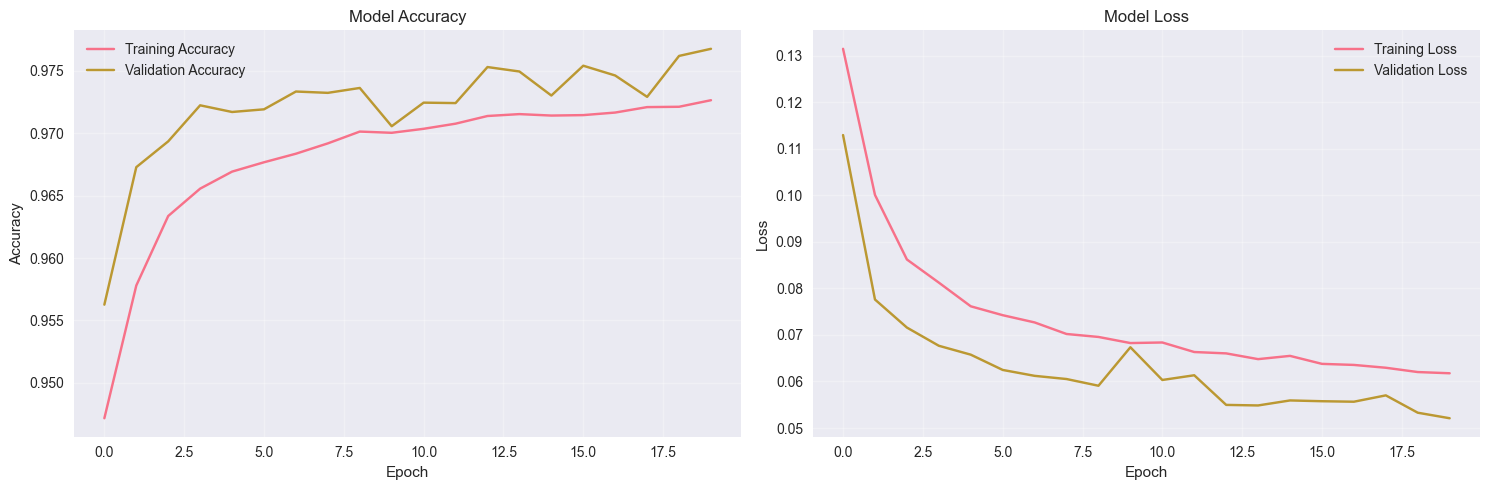


Evaluating Neural Network

Accuracy:  0.9787
Precision: 0.9789
Recall:    0.9787
F1 Score:  0.9786
ROC AUC:   0.9979

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     11200
           1       0.98      0.99      0.98     23869

    accuracy                           0.98     35069
   macro avg       0.98      0.97      0.98     35069
weighted avg       0.98      0.98      0.98     35069



Model saved to ../models/neural_network_model.h5


In [16]:
# Split training data for validation
from sklearn.model_selection import train_test_split
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Initialize and train Neural Network
nn_model = NeuralNetworkIDS(hidden_layers=[128, 64], dropout_rate=0.3)
nn_model.train(
    X_train_nn, y_train_nn, 
    X_val_nn, y_val_nn,
    epochs=20, 
    batch_size=32
)

# Plot training history
if nn_model.history:
    visualizer = IDSVisualizer()
    visualizer.plot_training_history(nn_model.history)

# Evaluate
nn_metrics, nn_evaluator = evaluate_model(
    nn_model, X_test, y_test,
    model_name="Neural Network",
    class_names=preprocessor.label_encoder.classes_ if hasattr(preprocessor.label_encoder, 'classes_') else None
)

# Save model
nn_model.save('../models/neural_network_model.h5')


## 5. Compare All Models


Model Comparison:
                accuracy  precision    recall  f1_score   roc_auc
Random Forest   0.989307   0.989353  0.989307  0.989276  0.999387
SVM             0.951153   0.951663  0.951153  0.950528  0.983406
Neural Network  0.978728   0.978883  0.978728  0.978605  0.997947


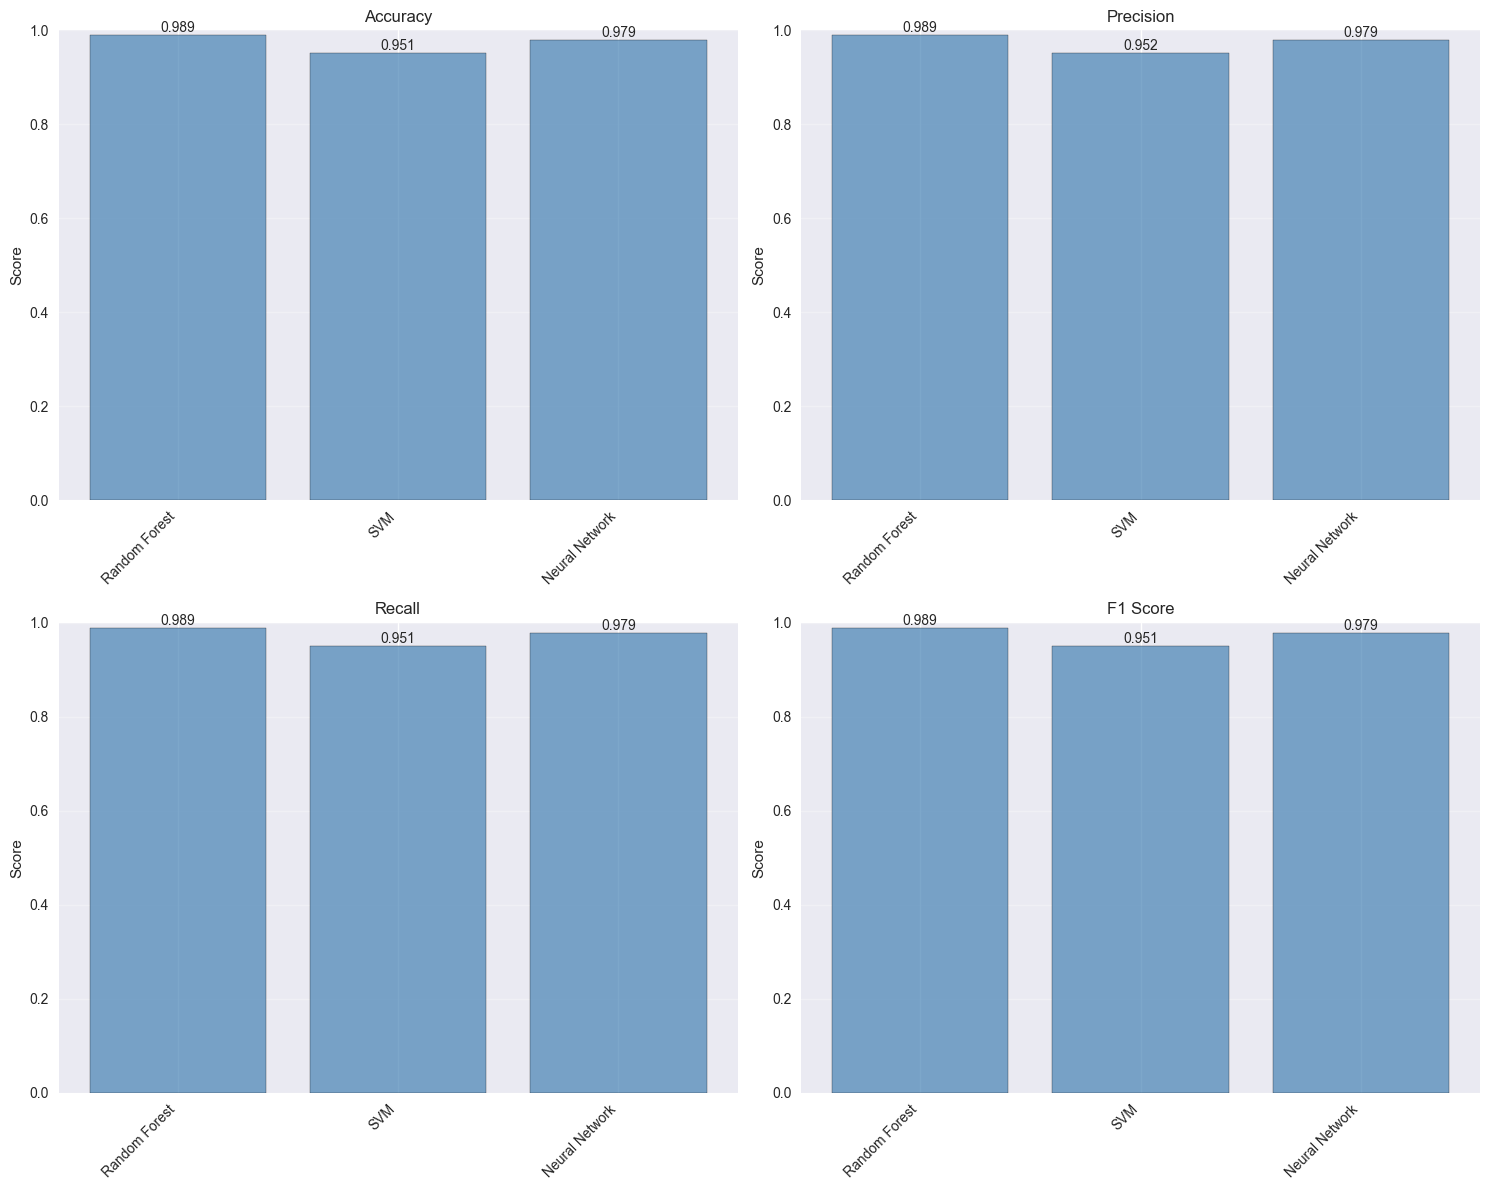


Comparison saved to ../models/model_comparison.csv


In [17]:
# Collect all results
results = {
    'Random Forest': rf_metrics,
    'SVM': svm_metrics,
    'Neural Network': nn_metrics
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
print("Model Comparison:")
print(comparison_df)

# Visualize comparison
visualizer = IDSVisualizer()
visualizer.plot_model_performance_comparison(results)

# Save comparison
comparison_df.to_csv('../models/model_comparison.csv')
print("\nComparison saved to ../models/model_comparison.csv")
